# Tuning CNNs(Practice)  SOLUTION

> [Click here](#new) to jump to new assignment solution code.

- For this assignment, you will continue working with the Dangerous Farm Insects data set from Kaggle: https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset

![img](https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1692317485__Screenshot20230817at81117PM.png)


## Getting Started

- Continue working in your repository from the previous practice assignment.
- Duplicate/make a copy of your previous notebook.
- Re-run your previous code to fit and evaluate your baseline model.

**Your ultimate goal is to build a new model that is better than the baseline model.**
 
## Tuning the Model
Use KerasTuner to tune at least 3 hyperparameters of your model:
- Create a build function with the 3 (or more) hyperparameters to tune.


- Create an instance of a Hyperband Tuner using your build function: 
    - Set the parameters for storing the results. Use: 
        - directory='KerasTuner/'
        - project_name='tuning-cnn1'
        - overwrite=True
    - Display the .search_space() of your tuner **before starting the search**.

- Tune your model with the tuner.search method:
    - Use your validation dataset as the validation_data
    - Set your objective as "val_accuracy"
    - Use epochs=20
 
After the search has completed:
- Display the tuner's .results_summary()
- Print the best parameters
- Extract the best model from the tuner and save as a new variable called `best_model`.

## Evaluate the Best Model
- Evaluate the best model on both the training and test sets. Include a confusion matrix, classification report, and the scores from model.evaluate. (Tip: use your evaluate_classification_network function).



## Previous Assignmnet Code

In [7]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

In [8]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
# from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
tf.__version__

'2.12.0'

In [9]:
# Custom functions: add to lesson notebook instead of file
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("../Functions/"))

import ann_functions as af

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Checking the contents of xrays folder
data_dir = "Data/Dangerous Insects/farm_insects/"
data_dir

'Data/Dangerous Insects/farm_insects/'

In [11]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1591

In [12]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(1250, 1000, 3)

In [13]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [14]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds

Found 1591 files belonging to 15 classes.
Metal device set to: Apple M1 Pro


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [15]:
## Set the size of the 
split_train = 0.8 #0.7
split_val = 0.1 #0.2
split_test = 0.1

# Calculate the number of batches for training and validation data 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 40 batches as training data
Use 5 batches as validation data
The remaining 5 batches will be used as test data.


In [16]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
len(train_ds)

40

In [17]:
## Create the val_ds from original ds

# 1. Skipping over the training batches
val_ds = ds.skip(n_train_batches)

# 2. Taking the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
len(val_ds)

5

In [18]:
# Create the test split from ds

# SKip over all of the training + val images
test_ds = ds.skip(n_train_batches + n_val_batches)
len(test_ds)

5

In [19]:
# checking the class names
class_names = ds.class_names
class_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

In [20]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

15

In [15]:
# Batch Size
batch_size

32

### Train-Test-Val Splits

In [16]:
# taking a sample banch to see batch shape
example_batch_imgs,example_batch_y= train_ds.take(1).get_single_element()
example_batch_imgs.shape

2023-08-24 21:34:32.387736: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


TensorShape([32, 128, 128, 3])

In [17]:
# individual image shape
# individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

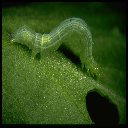

In [18]:
array_to_img(example_batch_imgs[0])

In [19]:
# Demo Unpacking shape
[*input_shape]

[128, 128, 3]

In [20]:
import datetime as dt

### Optimize Dataset Performance

In [21]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42)#.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache()#.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache()#.prefetch(buffer_size=AUTOTUNE)

### Training Baseline CNN

In [22]:
def build_model1(name='CNN1',input_shape=input_shape):
    
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3, # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,#64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax") )  

    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),#'adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    model.summary()
    return model

### Model 1: Basline Model

In [23]:
# build and  fit the neural network
model1 = build_model1(name='Model1')
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, )

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0    

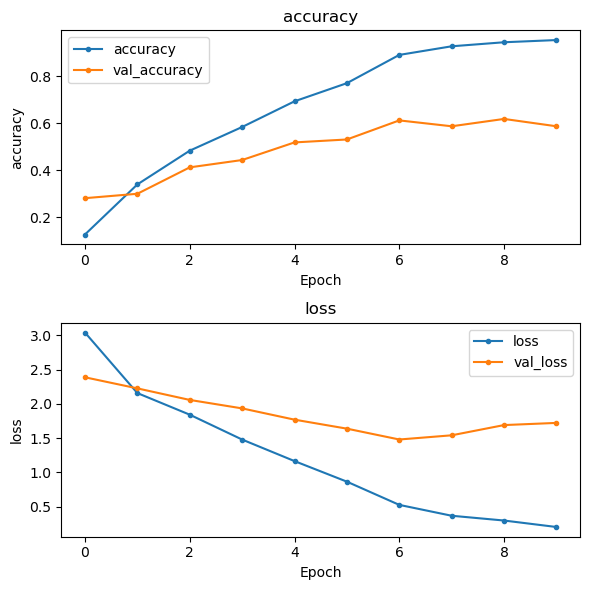


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       0.96      1.00      0.98        74
           2       0.84      0.96      0.90        81
           3       1.00      1.00      1.00        95
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        75
           6       1.00      1.00      1.00        91
           7       0.99      0.99      0.99        98
           8       1.00      1.00      1.00        90
           9       0.95      0.83      0.89        96
          10       1.00      0.95      0.98        83
          11       0.98      0.99      0.98        97
          12       0.98      0.98      0.98        87
          13       1.00      1.00    

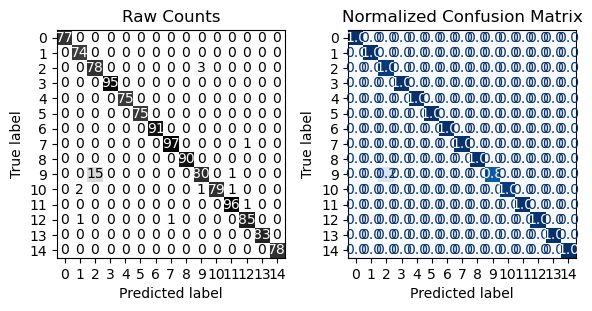


- Evaluating Training Data:
40/40 [==============================] - 0s 10ms/step - loss: 0.1258 - accuracy: 0.9789
{'loss': 0.12578247487545013, 'accuracy': 0.9789062738418579}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.22      0.25      0.24         8
           2       0.12      0.25      0.17         8
           3       0.55      0.67      0.60         9
           4       0.60      0.55      0.57        11
           5       0.91      0.71      0.80        14
           6       0.88      0.64      0.74        11
           7       0.40      0.40      0.40         5
           8       0.91      0.71      0.80        14
           9       0.33      0.43      0.38         7
          10       0.50      0.33      0.40      

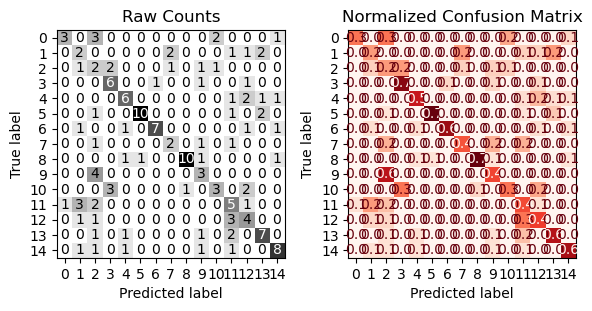


- Evaluating Test Data:
5/5 [==============================] - 0s 17ms/step - loss: 2.0146 - accuracy: 0.5166
{'loss': 2.014554262161255, 'accuracy': 0.5165562629699707}


In [24]:
# Evaluate on train and test
af.evaluate_classification_network(model1, X_train=train_ds, X_test=test_ds,
                                   figsize=(6,8),
                                  history=history, values_format=".1f");

## SOLUTION:  Tuning CNNs (Practice)

<!-- 
#### Tuning the Model
Use KerasTuner to tune at least 3 hyperparameters of your model:
- Create a build function with the 3 (or more) hyperparameters to tune.
- Create an instance of a Hyperband Tuner using your build function.
- Display the .search_space() of your tuner **before starting the search**.

- Tune your model with the tuner.search method:
    - Set the parameters for storing the results. Use: 
        - directory='KerasTuner/'
        - project_name='tuning-cnn1'
        - overwrite=True
    - Use your validation dataset as the validation_data
    - Set your objective as "val_accuracy"
    - Set your epochs to ~20
    -  `...`
 
After the search has completed:
- Display the tuner's .results_summary()
- Print the best parameters
- Extract the best model from the tuner and save as a new variable called `best_model`.
 -->

In [25]:
def build_model2(hp):
    
    model = models.Sequential(name='TunedModel')
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_1', 
                           min_value=32, 
                           max_value=64,
                           step=16),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'))
    
    # Pooling layer
    pool_padding = 'same'
    pool_strides = 2
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_2', 
                           min_value=32, 
                           max_value=64,
                           step=32),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same')) 

    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling




    # if hp.Boolean('batch_normalization'):
    #     model.add(layers.BatchNormalization())
        
    
    # Flattening layer
    model.add(layers.Flatten())

    # Tune n_dense layers
    n_layers = hp.Int('n_hidden_dense_layers', 
                          min_value=1,
                          max_value=3)
    n_units = hp.Float('n_units_dense',min_value=128,max_value=1024,step=128,)
    dropout_rate = hp.Float("drop_rate",min_value=0.0,
                                         max_value=0.5, step=0.1)
    for n in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))       
        # Add dropout
        model.add(layers.Dropout(dropout_rate))
    
        
        
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    # ## Tuning for Optimizer (classes)
    # chosen_optimizer = hp.Choice('optimizer',['adam','nadam','rmsprop'])
    # if chosen_optimizer=='adam':
    #     optimizer = tf.keras.optimizers.legacy.Adam()
    # elif chosen_optimizer=='nadam':
    #     optimizer =tf.keras.optimizers.legacy.Nadam()
    # elif chosen_optimizer=='rmsprop':
    #     optimizer = tf.keras.optimizers.legacy.RMSprop()

    

    ## Compile model   
    lr = hp.Float('learning_rate',min_value=.0001, max_value=10, step=10, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy',])
    
    model.summary()
    return model

In [26]:
def get_callbacks( ):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_accuracy')
    
    return [early_stopping]

In [27]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
import os

# Creating the directory for kerastuner's results
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [28]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(build_model2, objective='val_accuracy',
                        max_epochs=25, overwrite=True, directory=folder, 
                project_name='tuning-cnn1',)
tuner_hb.search_space_summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0

In [29]:
tuner_hb.search(train_ds,validation_data=val_ds, epochs=20)#, callbacks=get_callbacks())
tuner_hb.results_summary()

Trial 30 Complete [00h 00m 38s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.643750011920929
Total elapsed time: 00h 08m 23s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in KerasTuner/tuning-cnn1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
filters_1: 32
filters_2: 32
n_hidden_dense_layers: 2
n_units_dense: 384.0
drop_rate: 0.1
learning_rate: 0.001
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.643750011920929

Trial 0014 summary
Hyperparameters:
filters_1: 32
filters_2: 32
n_hidden_dense_layers: 2
n_units_dense: 384.0
drop_rate: 0.1
learning_rate: 0.001
tuner/epochs: 9
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0011
Score: 0.6000000238418579

Trial 0017 summary
Hyperparameters:
filters_1: 64
filters_2: 32
n_hidden_dense_layers: 1
n_units_dense: 768.0
drop_rate: 0.4
learning_rate: 0.001
tuner/epochs: 25
tune

In [30]:
best_hps = tuner_hb.get_best_hyperparameters()[0]
print(best_hps.values)

{'filters_1': 32, 'filters_2': 32, 'n_hidden_dense_layers': 2, 'n_units_dense': 384.0, 'drop_rate': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


In [31]:
best_model = tuner_hb.get_best_models()[0]
best_model.summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        77
           1       0.96      0.99      0.97        74
           2       0.93      0.68      0.79        81
           3       0.93      0.99      0.96        95
           4       1.00      0.95      0.97        75
           5       1.00      1.00      1.00        75
           6       0.99      0.99      0.99        91
           7       0.98      0.90      0.94        98
           8       0.94      0.98      0.96        90
           9       0.70      0.97      0.82        96
          10       0.95      0.88      0.91        83
          11       0.98      0.95      0.96        97
          12       0.86      0.99      0.92        87
          13       0.99      0.99    

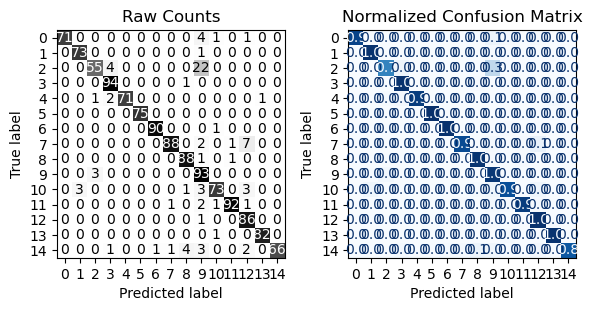


- Evaluating Training Data:
40/40 [==============================] - 1s 13ms/step - loss: 0.2657 - accuracy: 0.9352
{'loss': 0.2656726837158203, 'accuracy': 0.9351562261581421}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.20      0.12      0.15         8
           2       0.40      0.25      0.31         8
           3       0.60      0.67      0.63         9
           4       1.00      0.55      0.71        11
           5       0.75      0.64      0.69        14
           6       0.64      0.64      0.64        11
           7       0.67      0.40      0.50         5
           8       1.00      0.71      0.83        14
           9       0.22      0.71      0.33         7
          10       0.46      0.67      0.55       

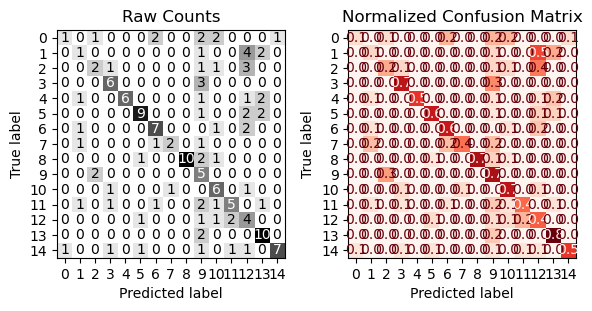


- Evaluating Test Data:
5/5 [==============================] - 0s 25ms/step - loss: 3.1887 - accuracy: 0.5364
{'loss': 3.188720703125, 'accuracy': 0.5364238619804382}


In [32]:
af.evaluate_classification_network(best_model,X_train=train_ds, X_test=test_ds,
                                   figsize=(6,8), values_format='.1f'
);